## Modeling for predicting critical outcome at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95

In [2]:
pd.set_option('display.max_columns', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.07053365376014503 : 1


### 3.  Modeling script

In [10]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.102495193481445 seconds
AUC: 0.844728597513773
AP(AUPRC): 0.31846220162093547
Sensitivity: 0.7859311740890689
Specificity: 0.7292919171676686
Score thresold: 0.058781732026283055


No handles with labels found to put in legend.


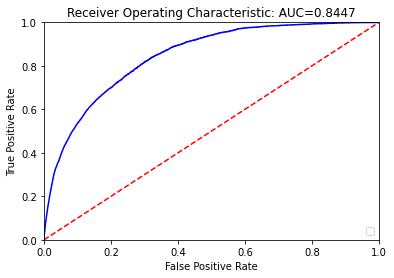

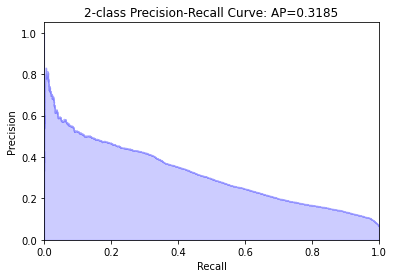

In [11]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 313.57187581062317 seconds
AUC: 0.8867800526990617
AP(AUPRC): 0.40798161701604124
Sensitivity: 0.8225371120107963
Specificity: 0.7934678881572669
Score thresold: 0.07015116449521101


No handles with labels found to put in legend.


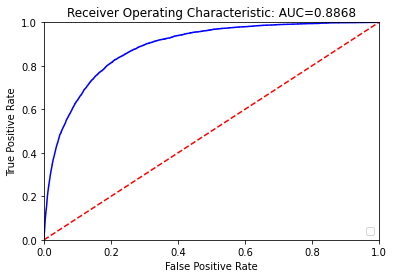

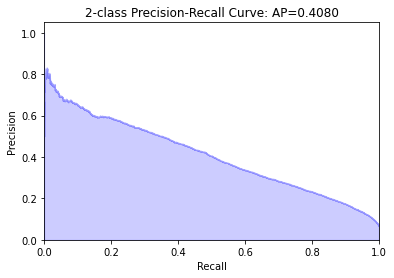

In [12]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 52.258278131484985 seconds
AUC: 0.8861782409848936
AP(AUPRC): 0.42330153043989527
Sensitivity: 0.8039811066126855
Specificity: 0.809631167096097
Score thresold: 0.08007539682539683


No handles with labels found to put in legend.


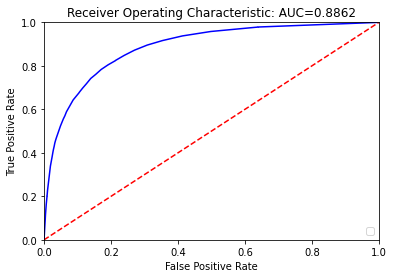

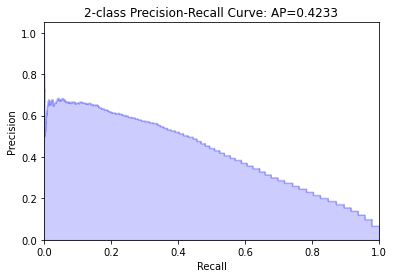

[0.10092467 0.0147791  0.00643302 0.0103844  0.01934734 0.00624598
 0.00983393 0.01661953 0.00295092 0.00635017 0.01171596 0.07742145
 0.09810206 0.05662309 0.06445728 0.09467614 0.08131366 0.05167654
 0.07334511 0.00558419 0.0060257  0.00366198 0.0014737  0.00217861
 0.00227852 0.00274371 0.00447346 0.00317161 0.00281304 0.00518625
 0.00565478 0.00493194 0.00519562 0.00279082 0.00718873 0.00262601
 0.00272764 0.00465008 0.00724116 0.00465923 0.00237566 0.0049326
 0.00526623 0.00280772 0.00379315 0.00110887 0.00679589 0.00460277
 0.00440084 0.00480827 0.0086179  0.00587874 0.00554084 0.0017163
 0.00534886 0.0054277  0.00445221 0.00711242 0.00221465 0.00441623
 0.0047974  0.00363231 0.00253865 0.00695664]


In [13]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 60.49981164932251 seconds
AUC: 0.8936031966896327
AP(AUPRC): 0.43713527537888847
Sensitivity: 0.8242240215924427
Specificity: 0.8042275026242962
Score thresold: 0.07080459175735267


No handles with labels found to put in legend.


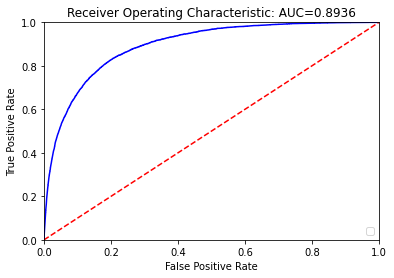

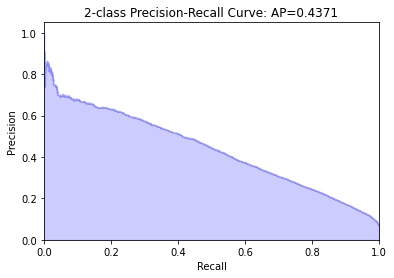

In [14]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [15]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

### 4. Performance output

In [16]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'roc_auc', 'average_precision', 'sensitivity', 'specificity', 'threshold', 'average_precision', 'lower_auroc', 'upper_auroc', 'lower_ap', 'upper_ap', 'lower_sensitivity', 'upper_sensitivity', 'lower_specificity', 'upper_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage.csv'), index=False)
result_df.head()

,Model,roc_auc,average_precision,sensitivity,specificity,threshold,average_precision,lower_auroc,upper_auroc,lower_ap,upper_ap,lower_sensitivity,upper_sensitivity,lower_specificity,upper_specificity,runtime
0,LR,0.844729,0.318462,0.785931,0.729292,0.058782,0.318462,0.844608,0.844899,0.318510,0.319407,0.772796,0.774434,0.740586,0.741608,5.102495
1,MLP,0.886780,0.407982,0.822537,0.793468,0.070151,0.407982,0.886626,0.886885,0.407559,0.408197,0.820325,0.821330,0.793074,0.793750,313.571876
2,RF,0.886178,0.423302,0.803981,0.809631,0.080075,0.423302,0.886106,0.886390,0.423595,0.424590,0.803483,0.804384,0.809684,0.809870,52.258278
3,GB,0.893603,0.437135,0.824224,0.804228,0.070805,0.437135,0.893467,0.893707,0.437026,0.437902,0.820318,0.821251,0.807374,0.808364,60.499812


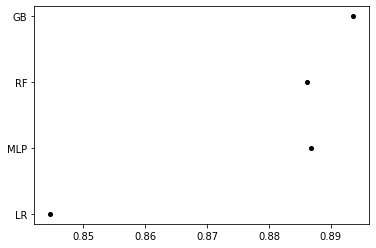

In [17]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df)

In [22]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
45,cci_HIV,0.001109
22,chiefcom_shortness_of_breath,0.001474
53,eci_Lymphoma,0.001716
23,chiefcom_back_pain,0.002179
58,eci_BloodLoss,0.002215
...,...,...
11,triage_temperature,0.077421
16,triage_dbp,0.081314
15,triage_sbp,0.094676
12,triage_heartrate,0.098102
